In [268]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
DATA_DIR = Path("./data")
DATA_FILEPATH = DATA_DIR / "renttherunway_final_data.json"
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


### Load data

In [269]:
df = pd.read_json(DATA_FILEPATH, lines=True)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [270]:
df = df[["fit", "user_id", "item_id", "size", "review_date", "category"]].rename(columns={"fit":"result"})
df.head()

,result,user_id,item_id,size,review_date,category
0,fit,420272,2260466,14,"April 20, 2016",romper
1,fit,273551,153475,12,"June 18, 2013",gown
2,fit,360448,1063761,4,"December 14, 2015",sheath
3,fit,909926,126335,8,"February 12, 2014",dress
4,fit,151944,616682,12,"September 26, 2016",gown


In [271]:
df.category.value_counts().values

array([92884, 44381, 19316,  5365,  5184,  4931,  3443,  3070,  2404,
        1751,  1531,  1149,   980,   782,   729,   651,   464,   422,
         278,   277,   241,   205,   188,   181,   162,   128,   125,
         123,   112,   107,   103,    87,    84,    75,    58,    57,
          55,    48,    48,    39,    34,    30,    22,    20,    18,
          17,    17,    16,    16,    15,    14,    14,    13,    12,
           8,     8,     7,     7,     7,     6,     6,     5,     4,
           4,     2,     2,     1,     1])

## Naive baseline model - probability over return status

In [272]:
class BaselineStatus:
    def __init__(self):
        pass
    def train_model(self, df):
        coldstart_df = df.value_counts('result')
        self.coldstart = coldstart_df.div(coldstart_df.sum())
        self.coldstart['predicted_result'] = self.coldstart.idxmax()

        df_encoded = pd.concat([df, pd.get_dummies(df["result"])], axis=1)
        sales_by_fit  = df_encoded[["item_id", "fit", "small", "large"]].groupby(["item_id"]).sum() + 1
        self.sales_probability_by_fit = sales_by_fit.div(sales_by_fit.sum(axis=1), axis=0)
        self.sales_probability_by_fit['predicted_result'] = self.sales_probability_by_fit.idxmax(axis=1)
        
    def predict(self, df):
        prediction = df.merge(self.sales_probability_by_fit, how='left', on='item_id')
        prediction = prediction.fillna(self.coldstart)
        return prediction
        


### Evaluation

In [273]:
def create_confusion_matrix(results):
    labels = ["fit", "small", "large"]
    confusion_m = pd.DataFrame(confusion_matrix(results['result'], results['predicted_result'], labels=labels), 
                                index=['true_'+l for l in labels], 
                                columns=['predicted_'+l for l in labels])
    return confusion_m
def show_confusion_matrix(results):
    confusion_m = create_confusion_matrix(results)
    sns.heatmap(confusion_m, annot=True, fmt='d')

def compute_mean_target_probability(results):
    return results.apply(lambda row: row[row['result']], axis=1).mean()

def compute_mean_log_probability(results):
    #return np.log(results.apply(lambda row: row[row['result']], axis=1)).mean()
    return results.apply(lambda row: np.log(row[row['result']]), axis=1).mean()


### Running Model on runttheway data

In [274]:
train, test = train_test_split(df, test_size=0.10)

In [275]:
bs = BaselineStatus()
bs.train_model(train)

In [276]:
bs.coldstart

result
fit                 0.737554
small               0.133863
large               0.128583
predicted_result         fit
dtype: object

In [277]:
results = bs.predict(test)

0.6172743664038934
-0.643433700223167


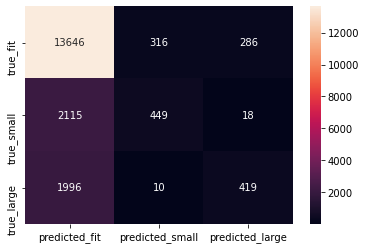

In [278]:
print(compute_mean_target_probability(results))
print(compute_mean_log_probability(results))
show_confusion_matrix(results)

0.6259185278996472
-0.612069699774052


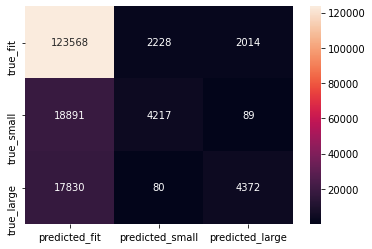

In [279]:
results_train = bs.predict(train)
print(compute_mean_target_probability(results_train))
print(compute_mean_log_probability(results_train))
show_confusion_matrix(results_train)

#### method tests

In [280]:
df_head = df.sort_values('item_id',ascending=False).head(20)
df_head

,result,user_id,item_id,size,review_date,category
154904,large,805395,2966087,24,"November 28, 2017",pants
190810,large,124186,2966087,28,"October 23, 2017",pants
72328,large,157411,2966087,12,"December 19, 2017",pants
141320,large,690751,2966087,12,"November 22, 2017",pants
18035,large,268448,2966087,28,"November 2, 2017",pants
78798,large,292436,2966087,16,"November 18, 2017",pants
48655,large,606519,2966087,24,"December 11, 2017",pants
179310,large,474580,2966087,20,"December 29, 2017",pants
108109,large,308564,2965924,16,"December 14, 2017",jacket
22393,fit,350583,2965924,20,"November 2, 2017",jacket


In [281]:
bs = BaselineStatus()
bs.train_model(df_head.head(18))

In [282]:
bs.sales_probability_by_fit

,fit,small,large,predicted_result
item_id,,,,
2964470,0.333333,0.333333,0.333333,fit
2965009,0.714286,0.142857,0.142857,fit
2965924,0.333333,0.166667,0.500000,large
2966087,0.090909,0.090909,0.818182,large


In [283]:
bs.coldstart

result
large               0.611111
fit                 0.333333
small               0.055556
predicted_result       large
dtype: object

In [284]:
results = bs.predict(df_head)
results

,result,user_id,item_id,size,review_date,category,fit,small,large,predicted_result
0,large,805395,2966087,24,"November 28, 2017",pants,0.090909,0.090909,0.818182,large
1,large,124186,2966087,28,"October 23, 2017",pants,0.090909,0.090909,0.818182,large
2,large,157411,2966087,12,"December 19, 2017",pants,0.090909,0.090909,0.818182,large
3,large,690751,2966087,12,"November 22, 2017",pants,0.090909,0.090909,0.818182,large
4,large,268448,2966087,28,"November 2, 2017",pants,0.090909,0.090909,0.818182,large
5,large,292436,2966087,16,"November 18, 2017",pants,0.090909,0.090909,0.818182,large
6,large,606519,2966087,24,"December 11, 2017",pants,0.090909,0.090909,0.818182,large
7,large,474580,2966087,20,"December 29, 2017",pants,0.090909,0.090909,0.818182,large
8,large,308564,2965924,16,"December 14, 2017",jacket,0.333333,0.166667,0.500000,large
9,fit,350583,2965924,20,"November 2, 2017",jacket,0.333333,0.166667,0.500000,large


0.6201298701298703
-0.5464611301655304


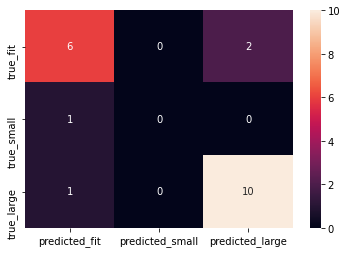

In [285]:
print(compute_mean_target_probability(results))
print(compute_mean_log_probability(results))
show_confusion_matrix(results)

## Hierarchical bayesian model
We will be using information about category to apply this model

self.sales at catego

In [304]:
class HierarchicalStatus:
    def __init__(self):
        self.w = np.random.beta(0.1, 1) #pd.Series(np.random.beta(0.1, 1, size=3), index=['fit', 'small', 'large'])
    
    #def alpha()
    
    def train_model(self, df):
        coldstart_df = df.value_counts('result')
        self.coldstart = coldstart_df#.div(coldstart_df.sum())
        self.coldstart['all'] = self.coldstart.sum()
        self.coldstart['predicted_result'] = self.coldstart[['fit', 'small', 'large']].idxmax()
        #self.coldstart['all'] = self.coldstart.sum()

        df_encoded = pd.concat([df, pd.get_dummies(df["result"])], axis=1)
        self.sales_at_article_level  = df_encoded[["item_id", "fit", "small", "large"]].groupby(["item_id"]).sum().rename(columns={'fit':'fit_by_article', 'small':'small_by_article', 'large':'large_by_article'}) #+ 1
        self.sales_at_article_level["all_by_article"] = self.sales_at_article_level.sum(axis=1)
        self.sales_at_category_level  = df_encoded[["category", "fit", "small", "large"]].groupby(["category"]).sum().rename(columns={'fit':'fit_by_category', 'small':'small_by_category', 'large':'large_by_category'}) #+ 1
        self.sales_at_category_level["all_by_category"] = self.sales_at_category_level.sum(axis=1)

        # self.sales_probability_by_fit = sales_by_fit.div(sales_by_fit.sum(axis=1), axis=0)
        # self.sales_probability_by_fit['predicted_result'] = self.sales_probability_by_fit.idxmax(axis=1)
        pass
        
    def predict(self, df):

        prediction = df.merge(self.sales_at_article_level, how='left', on='item_id')
        prediction = prediction.merge(self.sales_at_category_level, how='left', on='category')
        prediction = prediction.fillna(self.coldstart.rename({'fit':'fit_by_article', 'small':'small_by_article', 'large':'large_by_article', 'all':'all_by_article'}))

        for status in ['fit', 'small', 'large']:
            prediction[status] = ((prediction[status+"_by_article"] + self.w *prediction[status+'_by_category'])
                                / (prediction["all_by_article"] + self.w * prediction["all_by_category"]))
        

        prediction['predicted_result'] = prediction[['fit', 'small', 'large']].idxmax(axis=1)
        return prediction


In [305]:
hs = HierarchicalStatus()
hs.w

0.0002804661282650085

In [306]:
hs.train_model(train)

In [307]:
hs.coldstart

result
fit                 127810
small                23197
large                22282
all                 173289
predicted_result       fit
dtype: object

In [308]:
hs.sales_at_category_level

,fit_by_category,small_by_category,large_by_category,all_by_category
category,,,,
ballgown,9.0,1.0,5.0,15.0
blazer,533.0,61.0,106.0,700.0
blouse,437.0,57.0,95.0,589.0
blouson,9.0,1.0,2.0,12.0
bomber,84.0,17.0,13.0,114.0
...,...,...,...,...
trouser,32.0,12.0,5.0,49.0
trousers,13.0,5.0,0.0,18.0
tunic,92.0,5.0,48.0,145.0


In [309]:
hs.sales_at_article_level

,fit_by_article,small_by_article,large_by_article,all_by_article
item_id,,,,
123373,504.0,66.0,43.0,613.0
123793,1348.0,59.0,137.0,1544.0
124204,573.0,38.0,112.0,723.0
124553,250.0,21.0,170.0,441.0
125424,274.0,15.0,135.0,424.0
...,...,...,...,...
2963850,10.0,0.0,0.0,10.0
2964470,2.0,1.0,0.0,3.0
2965009,3.0,0.0,0.0,3.0


In [310]:
results = hs.predict(test)
results

,result,user_id,item_id,size,review_date,category,fit_by_article,small_by_article,large_by_article,all_by_article,fit_by_category,small_by_category,large_by_category,all_by_category,fit,small,large,predicted_result
0,fit,486887,1905844,16,"February 17, 2015",sheath,49.0,2.0,10.0,61.0,13145.0,2793.0,1468.0,17406.0,0.799716,0.042248,0.158036,fit
1,fit,862367,125465,46,"October 4, 2017",gown,642.0,132.0,12.0,786.0,31615.0,4268.0,4015.0,39898.0,0.816451,0.167083,0.016465,fit
2,fit,684117,1762904,20,"June 22, 2017",dress,10.0,2.0,8.0,20.0,59901.0,12309.0,11430.0,83640.0,0.616689,0.125460,0.257851,fit
3,fit,561520,1061890,8,"July 22, 2015",sheath,7.0,0.0,3.0,10.0,13145.0,2793.0,1468.0,17406.0,0.718107,0.052638,0.229255,fit
4,small,732903,1335648,13,"November 7, 2016",gown,89.0,9.0,9.0,107.0,31615.0,4268.0,4015.0,39898.0,0.828047,0.086277,0.085676,fit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19250,small,883593,859889,16,"July 11, 2016",dress,28.0,35.0,0.0,63.0,59901.0,12309.0,11430.0,83640.0,0.518172,0.444750,0.037078,fit
19251,large,668242,887695,4,"January 10, 2017",dress,35.0,3.0,16.0,54.0,59901.0,12309.0,11430.0,83640.0,0.668751,0.083300,0.247950,fit
19252,small,450296,152836,8,"December 27, 2016",mini,539.0,158.0,32.0,729.0,1183.0,286.0,120.0,1589.0,0.739372,0.216713,0.043915,fit
19253,small,475354,1205016,13,"December 17, 2015",gown,35.0,13.0,1.0,49.0,31615.0,4268.0,4015.0,39898.0,0.728807,0.235870,0.035323,fit


In [311]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19255 entries, 0 to 19254
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   result             19255 non-null  object 
 1   user_id            19255 non-null  int64  
 2   item_id            19255 non-null  int64  
 3   size               19255 non-null  int64  
 4   review_date        19255 non-null  object 
 5   category           19255 non-null  object 
 6   fit_by_article     19255 non-null  float64
 7   small_by_article   19255 non-null  float64
 8   large_by_article   19255 non-null  float64
 9   all_by_article     19255 non-null  float64
 10  fit_by_category    19255 non-null  float64
 11  small_by_category  19255 non-null  float64
 12  large_by_category  19255 non-null  float64
 13  all_by_category    19255 non-null  float64
 14  fit                19255 non-null  float64
 15  small              19255 non-null  float64
 16  large              192

0.6276759915646349


<ipython-input-273-d03c17cc9edd>:16: RuntimeWarning: divide by zero encountered in log
  return results.apply(lambda row: np.log(row[row['result']]), axis=1).mean()


-inf


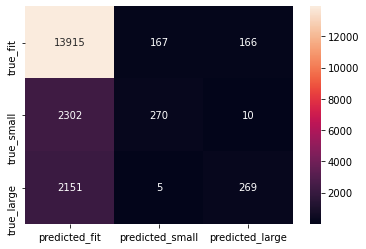

In [312]:
print(compute_mean_target_probability(results))
print(compute_mean_log_probability(results))
show_confusion_matrix(results)

Notatka: sprawdzić f1 score
auc (roc)

In [ ]:
duplikacja niepopularnych danych


## Baseline model - size

In [ ]:
class BaselineSize:
    def __init__(self):
        pass
    def train_model(self, df):
        coldstart_df = df.value_counts('result')
        self.coldstart = coldstart_df.div(coldstart_df.sum())
        self.coldstart['predicted_result'] = self.coldstart.idxmax()

        df_encoded = pd.concat([df, pd.get_dummies(df["result"])], axis=1)
        sales_by_fit  = df_encoded[["item_id", "fit", "small", "large"]].groupby(["item_id"]).sum() + 1
        self.sales_probability_by_fit = sales_by_fit.div(sales_by_fit.sum(axis=1), axis=0)
        self.sales_probability_by_fit['predicted_result'] = self.sales_probability_by_fit.idxmax(axis=1)
        
    def predict(self, df):
        prediction = df.merge(self.sales_probability_by_fit, how='left', on='item_id')
        prediction = prediction.fillna(self.coldstart)
        return prediction